<a href="https://colab.research.google.com/github/ram130849/GANs/blob/main/DCGAN_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.6 MB/s 


In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import random
import numpy as np
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.conv import Conv2d
%matplotlib inline

In [3]:
manual_seed = 329
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [4]:
data_root = 'data/celeba' # Dataset Directory.

workers = 2 # Number of parallel workers.

batch_size = 128 # Batch Size

image_size = 64 # Size of Image - H * W

nc = 3 # Number of Channels

nz = 100 # Size of latent Vector

ngf = 64 # No of feature maps in Generator.

ndf = 64 # No of feature maps in discriminator.

no_epochs = 15 # No of Epochs.

lr = 0.001 # Learning Rate.

beta1 = 0.5 # Beta HyperParameters for Adam Optimizer.

ngpu = 1 # Number of GPU's available. Use 0 for CPU Mode.

In [5]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [6]:
# gdrive_path = 'https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ'

In [7]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# file_id = '0B7EVK8r0v71pZjFTYXZWM3FlRnM'
# downloaded = drive.CreateFile({'id':file_id})
# downloaded.FetchMetadata(fetch_all=True)
# downloaded.GetContentFile('img_align_celeba.zip')

In [6]:
dataset = datasets.CelebA(root='/content/',transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]),download=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

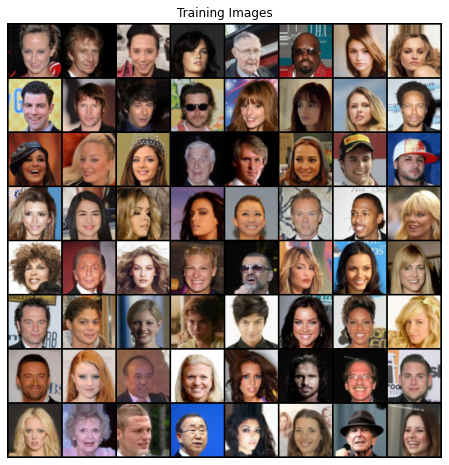

In [7]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if(classname.find('Conv')!=-1):
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif(classname.find('Batch')!=-1):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
class Generator(nn.Module):
    def __init__(self,ngpu):
          super(Generator,self).__init__()
          self.ngpu = ngpu
          self._generate = nn.Sequential(
              # input is Z, going into a Convolution. nz - Size of Latent Vector, ngf*8 - (512).
              nn.ConvTranspose2d(in_channels=nz,out_channels=ngf*8,kernel_size=4,stride=1,padding=0,bias=False),
              nn.BatchNorm2d(ngf*8),
              nn.LeakyReLU(True),

              #state size. (ngf*4)*8*8. ngf*8 - number of Feature maps in Generator (512), ngf*4 - (256).
              nn.ConvTranspose2d(in_channels=ngf * 8,out_channels=ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(ngf*4),
              nn.ReLU(True),

              #state size. (ngf*8)*16*16. ngf*4 - no of generator feature maps (256) ngf*2 - no of generator feature maps. (128)
              nn.ConvTranspose2d(in_channels=ngf * 4,out_channels=ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(ngf*2),
              nn.ReLU(True),
              #state size. (ngf*2)*16*16. # ngf*2 - no of generator feature maps (128), ngf - (64)
              nn.ConvTranspose2d(in_channels=ngf * 2,out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(ngf),
              nn.ReLU(True),
              # state size. (ngf)*32*32 # ngf - number of generator feature maps, nc - number of channels.
              nn.ConvTranspose2d( in_channels=ngf,out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
              nn.Tanh()
              # state size. (nc)*64*64
          )
    def forward(self,x):
        return self._generate(x)

In [10]:
netG = Generator(ngpu).to(device)

In [11]:
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (_generate): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1

In [12]:
class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator,self).__init__()
        self.ngpu = ngpu
        self._discriminate = nn.Sequential(
              # Input size is nc*64*64
              nn.Conv2d(in_channels=nc,out_channels=ndf,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(ndf),
              nn.LeakyReLU(0.2,inplace=True),

              # Input Channels - ndf, Output_Channels - ndf*2 
              nn.Conv2d(in_channels=ndf,out_channels=ndf*2,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(ndf*2),
              nn.LeakyReLU(0.2,inplace=True),

              # Input Channels - ndf*2, Output_Channels - ndf*4 
              nn.Conv2d(in_channels=ndf*2,out_channels=ndf*4,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(ndf*4),
              nn.LeakyReLU(0.2,inplace=True),

              # Input Channels - ndf*4, Output_Channels - ndf*8 
              nn.Conv2d(in_channels=ndf*4,out_channels=ndf*8,kernel_size=4,stride=2,padding=1,bias=False),
              nn.BatchNorm2d(ndf*8),
              nn.LeakyReLU(0.2,inplace=True),
              # state size. Input Channels - ndf*8, Output Channels - 1
              nn.Conv2d(in_channels=ndf*8,out_channels=1,kernel_size=4,stride=1,padding=0,bias=False),
              nn.Sigmoid()
        )
    def forward(self,x):
        return self._discriminate(x)

In [13]:
netD = Discriminator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (_discriminate): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kern

In [14]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator. nz - Size of latent Vector
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
img_list = []
D_loss = []
G_loss = []
iters = 0

for epoch in range(no_epochs):
    for i,data in enumerate(dataloader): 
        # Update D network: log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        label = torch.full((b_size,),real_label,dtype=torch.float,device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output,label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size,nz,1,1,device=device)

        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output,label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D

        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output Training Statistics:
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'% (epoch, no_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            # Save Losses for plotting later
        G_loss.append(errG.item())
        D_loss.append(errD.item())

        if (iters%500 == 0) or ((epoch == no_epochs-1) and (i==len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake,padding=1,normalize=True))
        
        iters+=1

[0/15][0/1272]	Loss_D: 1.8531	Loss_G: 1.8474	D(x): 0.3196	D(G(z)): 0.3504 / 0.2145
[0/15][50/1272]	Loss_D: 0.2125	Loss_G: 12.1050	D(x): 0.9475	D(G(z)): 0.0745 / 0.0016
[0/15][100/1272]	Loss_D: 1.1783	Loss_G: 2.8132	D(x): 0.6970	D(G(z)): 0.3139 / 0.1460
[0/15][150/1272]	Loss_D: 1.0035	Loss_G: 2.2348	D(x): 0.6853	D(G(z)): 0.3739 / 0.1855
[0/15][200/1272]	Loss_D: 1.1036	Loss_G: 2.9274	D(x): 0.7722	D(G(z)): 0.4912 / 0.0792
[0/15][250/1272]	Loss_D: 1.0434	Loss_G: 1.8194	D(x): 0.6377	D(G(z)): 0.3657 / 0.2186
[0/15][300/1272]	Loss_D: 1.6271	Loss_G: 3.7610	D(x): 0.7574	D(G(z)): 0.6756 / 0.0355
[0/15][350/1272]	Loss_D: 1.1159	Loss_G: 1.6321	D(x): 0.6215	D(G(z)): 0.3807 / 0.2288
[0/15][400/1272]	Loss_D: 1.6617	Loss_G: 2.1208	D(x): 0.7162	D(G(z)): 0.6686 / 0.1516
[0/15][450/1272]	Loss_D: 1.3340	Loss_G: 1.4223	D(x): 0.6024	D(G(z)): 0.4872 / 0.2720
[0/15][500/1272]	Loss_D: 2.4799	Loss_G: 5.0311	D(x): 0.6966	D(G(z)): 0.8143 / 0.0099
[0/15][550/1272]	Loss_D: 1.6879	Loss_G: 1.9328	D(x): 0.5175	D(G(z))

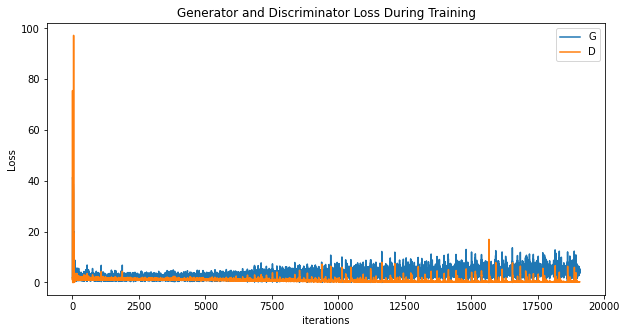

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

[]

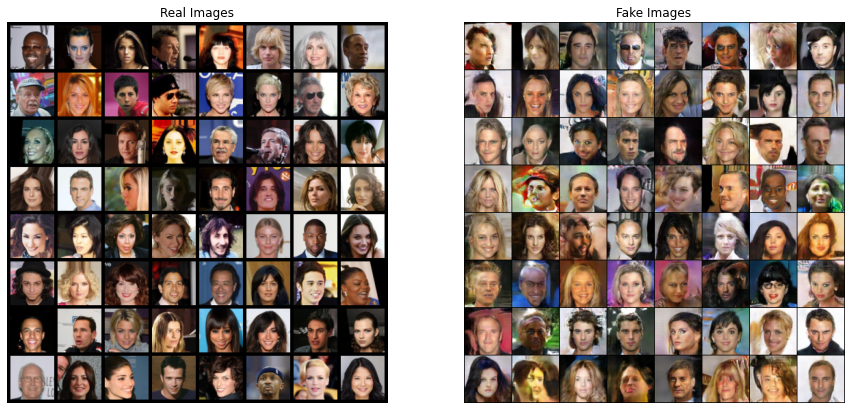

In [17]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
# Plot the Real Images.
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=5,normalize=True).cpu(),(1,2,0)))
# Plot the Fake Images.
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.plot()